# cross-section as a function of the proton kinematics

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline
sns.set(font_scale=2);sns.set_style("whitegrid");

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


## load mc and data

In [6]:
versions['overlay date'] = '2018_08_16'
versions['Overlay'] = 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2'
versions['data date'] = '2018_08_16'
versions['beam on'] = 'prod_reco_optfilter_bnb_v12_unblind_mcc8'
versions['beam off'] = 'prod_reco_optfilter_extbnb_v12_mcc8_dev'
selected_overlay,selected_overlay_concat,selected_CC1p,genie_CC1p,selected_beam_on,selected_beam_off = load_mc_and_data()

did not find selected_cosmic.csv, so creating it...
285009 ccqe candidate pairs, 180070 in FV
74387 are 1mu-1p, 41.3%
55226 are other-pairs, 30.7%
155396 are cosmic, 86.3%
--------------------------------------------------------------
36843 are CC1p0pi, 20.5%
--------------------------------------------------------------
40729 are CC1p, 22.6%
I finished loading overlay samples. We have in total 285009 pairs
applied cuts to overlay
saved selected 1mu-1p to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_1mu-1p.csv
saved selected other-pairs to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_other-pairs.csv
saved selected cosmic to /Users/erezcohen/Desktop/uBoone/CCQEanalysis/Xsec/selected_events/prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2_2018_08_16_selected_cosmic.csv
saved selected CC1p0pi to /Users/erezcohen/Desktop/

## divide into 3 dimentions: 

In [7]:
for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins+1)
bins1,bins2,bins3 = Bins['Pp'], Bins['cos(theta(p))'] , Bins['phi(p)']
N1,N2,N3 = len(bins1)-1,len(bins2)-1,len(bins3)-1

In [8]:
def compute_Xsec_in_3d(beam_on=None,beam_off=None
                       ,generated_CC1p=None,selected_CC1p=None,overlay=None
                       ,NBins=5):
    # the return is a dictionary of results    
    for key in Limits.keys(): Bins[key] = np.linspace(Limits[key][0],Limits[key][1],NBins+1)
    global bins1,bins2,bins3,N1,N2,N3
    bins1,bins2,bins3 = Bins['Pp'], Bins['cos(theta(p))'] , Bins['phi(p)']
    N1,N2,N3 = len(bins1)-1,len(bins2)-1,len(bins3)-1
        
    h = dict()
    keys = ['on','off scaled','generated','CC1p','CC1p scaled','B','eff','eff err'
              ,'Xsec','Xsec err','mc-Xsec','mc-Xsec err','generated-Xsec','generated-Xsec err']
    for key in keys: h[key] = np.zeros((N1,N2,N3))
    N = dict()
    for i_P in range(N1):#{
        Pmin,Pmax = bins1[i_P],bins1[i_P+1]
        P_bin_width = Pmax - Pmin
        
        for i_cos_theta in range(N2):#{
            cos_theta_min,cos_theta_max = bins2[i_cos_theta],bins2[i_cos_theta+1]
            cos_theta_bin_width = cos_theta_max - cos_theta_min

            for i_phi in range(N3):#{
                phi_min,phi_max = bins3[i_phi],bins3[i_phi+1]
                phi_bin_width = phi_max - phi_min
                
                bin_width = P_bin_width * cos_theta_bin_width * phi_bin_width

                beam_on_in_bin = sam_in_3d_bin(beam_on,
                                               'reco_Pp',Pmin,Pmax,
                                               'reco_Pp_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pp_phi',phi_min,phi_max)
                N['on'] = len(beam_on_in_bin)
                h['on'][i_P][i_cos_theta][i_phi] = N['on']

                Xsec_in_bin , Xsec_err_in_bin = 0 , 0
                mc_Xsec_in_bin , mc_Xsec_err_in_bin = 0 , 0
                gen_Xsec_in_bin , gen_Xsec_err_in_bin = 0 , 0

                N['off'] = len(sam_in_3d_bin(beam_off,
                                               'reco_Pp',Pmin,Pmax,
                                               'reco_Pp_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pp_phi',phi_min,phi_max))
                N['off scaled'] = N['off']*OffBeam_scaling
                h['off scaled'][i_P][i_cos_theta][i_phi] = N['off scaled']

                N['generated'] = len(sam_in_3d_bin(generated_CC1p,
                                               'truth_Pp',Pmin,Pmax,
                                               'truth_Pp_cos_theta',cos_theta_min,cos_theta_max,
                                               'truth_Pp_phi',phi_min,phi_max) )
                N['generated scaled'] = N['generated']*Nevents['f(POT)']
                h['generated'][i_P][i_cos_theta][i_phi] = N['generated']

                N['CC1p'] = len(sam_in_3d_bin(selected_CC1p,
                                               'reco_Pp',Pmin,Pmax,
                                               'reco_Pp_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pp_phi',phi_min,phi_max))
                h['CC1p'][i_P][i_cos_theta][i_phi] = N['CC1p']

                N['CC1p scaled'] = N['CC1p']*Nevents['f(POT)']
                h['CC1p scaled'][i_P][i_cos_theta][i_phi] = N['CC1p scaled']

                   
                N['ovrelay'] = len(sam_in_3d_bin(overlay,
                                               'reco_Pp',Pmin,Pmax,
                                               'reco_Pp_cos_theta',cos_theta_min,cos_theta_max,
                                               'reco_Pp_phi',phi_min,phi_max))
                N['ovrelay scaled'] = N['ovrelay']*Nevents['f(POT)']
                    
                B, B_err = N['ovrelay scaled'] - N['CC1p scaled'] , np.sqrt(N['ovrelay scaled'] - N['CC1p scaled'])
                h['B'][i_P][i_cos_theta][i_phi] = B

                eff, eff_err = get_eff(Ngen=N['generated'] , Nsel=N['CC1p'])
                h['eff'][i_P][i_cos_theta][i_phi] = eff
                h['eff err'][i_P][i_cos_theta][i_phi] = eff_err
                    
                Xsec_in_bin,Xsec_err_in_bin = compute_Xsec(Non=N['on'], Noff=N['off'], B=B, eff=eff, 
                                                               bin_width = bin_width,
                                                               Non_err = np.sqrt(N['on']),
                                                               Noff_err= np.sqrt(N['off']),
                                                               B_err   = B_err, eff_err = eff_err)
                
                mc_Xsec_in_bin,mc_Xsec_err_in_bin = compute_Xsec(Non=N['CC1p scaled'], eff=eff,
                                                                     bin_width = bin_width,
                                                                     Non_err = np.sqrt(N['CC1p'])*Nevents['f(POT)'],
                                                                     eff_err = eff_err)
                
                gen_Xsec_in_bin,gen_Xsec_err_in_bin = compute_Xsec(Non=N['generated scaled'], eff=1,
                                                                     bin_width = bin_width,
                                                                     Non_err = np.sqrt(N['generated'])*Nevents['f(POT)'])
                h['Xsec'][i_P][i_cos_theta][i_phi] = Xsec_in_bin
                h['Xsec err'][i_P][i_cos_theta][i_phi] = Xsec_err_in_bin
                h['mc-Xsec'][i_P][i_cos_theta][i_phi] = mc_Xsec_in_bin
                h['mc-Xsec err'][i_P][i_cos_theta][i_phi] = mc_Xsec_err_in_bin
                h['generated-Xsec'][i_P][i_cos_theta][i_phi] = gen_Xsec_in_bin
                h['generated-Xsec err'][i_P][i_cos_theta][i_phi] = gen_Xsec_err_in_bin                
            #} i_phi
        #} i_cos_theta
    #} i_P
    print 'done.'    
    return h

# 5 bins for each variable

In [9]:
h = compute_Xsec_in_3d(beam_on=selected_beam_on,
                       beam_off=selected_beam_off,                       
                       generated_CC1p=genie_CC1p,                       
                       selected_CC1p=selected_CC1p,                       
                       overlay=selected_overlay_concat,NBins=5)

done.


In [10]:
# integrated cross-section
def get_integrated_Xsec(h=None):
    global bins1,bins2,bins3,N1,N2,N3
    Xsec_integrated,Xsec_integrated_err_sq_sum = 0,0
    mc_Xsec_integrated,mc_Xsec_integrated_err_sq_sum = 0,0
    generated_Xsec_integrated,generated_Xsec_integrated_err_sq_sum = 0,0

    for i_P in range(N1):#{
        P_bin_width = bins1[i_P+1] - bins1[i_P]
        for i_cos_theta in range(N2):#{
            cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]
            for i_phi in range(N3):#{
                phi_bin_width = bins3[i_phi+1] - bins3[i_phi]

                bin_width = P_bin_width * cos_theta_bin_width * phi_bin_width
                Xsec_integrated += h['Xsec'][i_P][i_cos_theta][i_phi]*bin_width
                Xsec_integrated_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi]*bin_width)
                mc_Xsec_integrated += h['mc-Xsec'][i_P][i_cos_theta][i_phi]*bin_width
                mc_Xsec_integrated_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi]*bin_width)
                generated_Xsec_integrated += h['generated-Xsec'][i_P][i_cos_theta][i_phi]*bin_width
                generated_Xsec_integrated_err_sq_sum += np.square(h['generated-Xsec err'][i_P][i_cos_theta][i_phi]*bin_width)


    Xsec_integrated_err = np.sqrt(Xsec_integrated_err_sq_sum)
    print 'Xsec_integrated: %.2f ± %.2f'%(Xsec_integrated,Xsec_integrated_err),'e-39 cm2'
    mc_Xsec_integrated_err = np.sqrt(mc_Xsec_integrated_err_sq_sum)
    print 'mc_Xsec_integrated: %.2f ± %.2f'%(mc_Xsec_integrated,mc_Xsec_integrated_err),'e-39 cm2'
    generated_Xsec_integrated_err = np.sqrt(generated_Xsec_integrated_err_sq_sum)
    print 'generated_Xsec_integrated: %.2f ± %.2f'%(generated_Xsec_integrated,generated_Xsec_integrated_err),'e-39 cm2'

    return Xsec_integrated,Xsec_integrated_err,mc_Xsec_integrated,mc_Xsec_integrated_err,generated_Xsec_integrated,generated_Xsec_integrated_err

In [11]:
Xsec,Xsec_err,mc_Xsec,mc_Xsec_err,gen_Xsec,gen_Xsec_err = get_integrated_Xsec(h=h)

Xsec_integrated: 3.84 ± 0.34 e-39 cm2
mc_Xsec_integrated: 5.57 ± 0.10 e-39 cm2
generated_Xsec_integrated: 5.97 ± 0.03 e-39 cm2


# single-differential as a function of $p_p$ 

In [34]:
Xsec_1d,Xsec_1d_err = np.zeros(N1),np.zeros(N1)
mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N1),np.zeros(N1)
gen_Xsec_1d,gen_Xsec_1d_err = np.zeros(N1),np.zeros(N1)
for i_P in range(N1):#{
    Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum,gen_Xsec_1d_err_sq_sum = 0,0,0
    for i_cos_theta in range(N2):#{
        cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]
        for i_phi in range(N3):#{
            phi_bin_width = bins3[i_phi+1] - bins3[i_phi]            
            Xsec_1d[i_P] += h['Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
            Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
            mc_Xsec_1d[i_P] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
            mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
            gen_Xsec_1d[i_P] += h['generated-Xsec'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width
            gen_Xsec_1d_err_sq_sum += np.square(h['generated-Xsec err'][i_P][i_cos_theta][i_phi] * cos_theta_bin_width * phi_bin_width)
        #}
    #}        
    Xsec_1d_err[i_P] = np.sqrt(Xsec_1d_err_sq_sum)
    mc_Xsec_1d_err[i_P] = np.sqrt(mc_Xsec_1d_err_sq_sum)
    gen_Xsec_1d_err[i_P] = np.sqrt(gen_Xsec_1d_err_sq_sum)
#}
print 'integrated Xsec:',np.sum([Xsec_1d[i_P]*(bins1[i_P+1]-bins1[i_P]) for i_P in range(N1)]),'e-39 cm2'

integrated Xsec: 3.84125465209 e-39 cm2


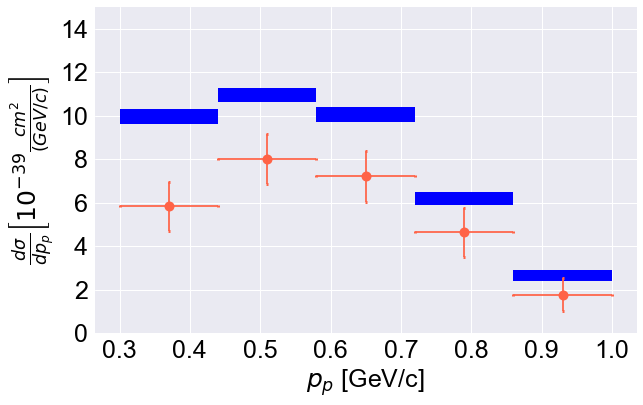

In [35]:
# sns.set_style("whitegrid");
observable = 'Pp'
bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
fig,ax = plt.subplots(figsize=(9.708,6))
ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=bin_width, color=Colors['CC1p'], label=r'mc')
ax.errorbar( x=mid , xerr=0.5*bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                    , color=Colors['beam on'], capsize=1, capthick=3, label='data')
set_axes(ax,xlabel,y_label=r'$\frac{d\sigma}{d'+vlabel+'}$' +r'$\left[10^{-39} \frac{cm^{2}}{(%s)}\right]$'%units ,do_add_legend=False
         ,ylim=(0,15))

## save to csv...

In [36]:
name = 'single_differential_Xsec_Pp_%d_bins'%(len(mid))
np.savetxt(Paths['1d Xsec'] + name + ".csv" , Xsec_1d , delimiter=",")
np.savetxt(Paths['1d Xsec'] + name + "_err.csv" , Xsec_1d_err , delimiter=",")
np.savetxt(Paths['1d Xsec'] + 'overlay_' + name + ".csv" , mc_Xsec_1d , delimiter=",")
np.savetxt(Paths['1d Xsec'] + 'overlay_' + name + "_err.csv" , mc_Xsec_1d_err , delimiter=",")
print 'saved',name + ".csv"

saved single_differential_Xsec_Pp_5_bins.csv


# single-differential as a function of $\cos\theta_p$ 

In [37]:
Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N2),np.zeros(N2),np.zeros(N2),np.zeros(N2)
for i_cos_theta in range(N2):#{
    Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
    for i_P in range(N1):#{
        P_bin_width = bins1[i_P+1] - bins1[i_P]
        for i_phi in range(N3):#{
            phi_bin_width = bins3[i_phi+1] - bins3[i_phi]
            
            Xsec_1d[i_cos_theta] += h['Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width
            Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width)
            mc_Xsec_1d[i_cos_theta] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width
            mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * phi_bin_width)
        #}
    #}        
    Xsec_1d_err[i_cos_theta] = np.sqrt(Xsec_1d_err_sq_sum)
    mc_Xsec_1d_err[i_cos_theta] = np.sqrt(mc_Xsec_1d_err_sq_sum)
#}
Xsec_1d,Xsec_1d_err = np.array(Xsec_1d),np.array(Xsec_1d_err)
mc_Xsec_1d,mc_Xsec_1d_err = np.array(mc_Xsec_1d),np.array(mc_Xsec_1d_err)
print 'integrated Xsec:',np.sum([Xsec_1d[i_cos_theta]*(bins2[i_cos_theta+1]-bins2[i_cos_theta]) for i_cos_theta in range(N2)]),'e-39 cm2'

integrated Xsec: 3.84125465209 e-39 cm2


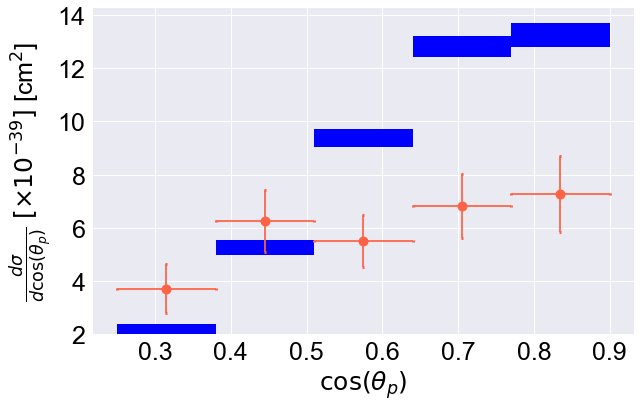

In [38]:
observable = 'cos(theta(p))'
bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
xlabel=Vlabel
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
fig,ax = plt.subplots(figsize=(9.708,6))
ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=2*bin_width, color=Colors['CC1p'], label=r'mc ($\Delta_{stat.}$)')
ax.errorbar( x=mid , xerr=bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                    , color=Colors['beam on'], capsize=1, capthick=3, label='data')
set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                       +r' $\left[\times 10^{-39}\right]$ '
                       +r'[cm$^{2}$]')
         ,do_add_legend=False)

## save to csv...

In [39]:
name = 'single_differential_Xsec_Pp_cos_theta_%d_bins'%(len(mid))
np.savetxt(Paths['1d Xsec'] + name + ".csv" , Xsec_1d , delimiter=",")
np.savetxt(Paths['1d Xsec'] + name + "_err.csv" , Xsec_1d_err , delimiter=",")
np.savetxt(Paths['1d Xsec'] + 'overlay_' + name + ".csv" , mc_Xsec_1d , delimiter=",")
np.savetxt(Paths['1d Xsec'] + 'overlay_' + name + "_err.csv" , mc_Xsec_1d_err , delimiter=",")
print 'saved',name + ".csv"

saved single_differential_Xsec_Pp_cos_theta_5_bins.csv


# single-differential as a function of $\phi_p$ 

In [40]:
Xsec_1d,Xsec_1d_err,mc_Xsec_1d,mc_Xsec_1d_err = np.zeros(N3),np.zeros(N3),np.zeros(N3),np.zeros(N3)
for i_phi in range(N3):#{
    Xsec_1d_err_sq_sum,mc_Xsec_1d_err_sq_sum = 0,0
    for i_P in range(N1):#{
        P_bin_width = bins1[i_P+1] - bins1[i_P]
        for i_cos_theta in range(N2):#{
            cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta]            
            Xsec_1d[i_phi] += h['Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width
            Xsec_1d_err_sq_sum += np.square(h['Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width)
            mc_Xsec_1d[i_phi] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width
            mc_Xsec_1d_err_sq_sum += np.square(h['mc-Xsec err'][i_P][i_cos_theta][i_phi] * P_bin_width * cos_theta_bin_width)
        #}
    #}        
    Xsec_1d_err[i_phi] = np.sqrt(Xsec_1d_err_sq_sum)
    mc_Xsec_1d_err[i_phi] = np.sqrt(mc_Xsec_1d_err_sq_sum)
#}
Xsec_1d,Xsec_1d_err = np.array(Xsec_1d),np.array(Xsec_1d_err)
mc_Xsec_1d,mc_Xsec_1d_err = np.array(mc_Xsec_1d),np.array(mc_Xsec_1d_err)
print 'integrated Xsec:',np.sum([Xsec_1d[i_phi]*(bins3[i_phi+1]-bins3[i_phi]) for i_phi in range(N3)]),'e-39 cm2'

integrated Xsec: 3.84125465209 e-39 cm2


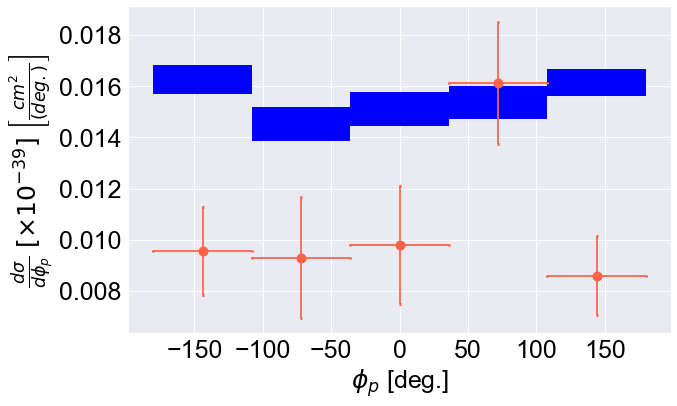

In [41]:
observable = 'phi(p)'
bins=Bins[observable]; vlabel=vlabels[observable]; Vlabel=Vlabels[observable]; units=Units[observable]
xlabel=Vlabel+' ['+units+']'
mid = 0.5*(bins[1:]+bins[:-1]); bin_width=0.5*(mid[1]-mid[0])
fig,ax = plt.subplots(figsize=(9.708,6))
ax.bar( x=mid , height=2*mc_Xsec_1d_err, bottom=mc_Xsec_1d-mc_Xsec_1d_err, width=2*bin_width, color=Colors['CC1p'], label=r'mc ($\Delta_{stat.}$)')
ax.errorbar( x=mid , xerr=bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10
                    , color=Colors['beam on'], capsize=1, capthick=3, label='data')
set_axes(ax,xlabel
             ,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$'
                       +r' $\left[\times 10^{-39}\right]$ '
                       +r'$\left[\frac{cm^{2}}{(%s)}\right]$'%units)
         ,do_add_legend=False)

## save to csv...

In [42]:
name = 'single_differential_Xsec_Pp_phi_%d_bins'%(len(mid))
np.savetxt(Paths['1d Xsec'] + name + ".csv" , Xsec_1d , delimiter=",")
np.savetxt(Paths['1d Xsec'] + name + "_err.csv" , Xsec_1d_err , delimiter=",")
np.savetxt(Paths['1d Xsec'] + 'overlay_' + name + ".csv" , mc_Xsec_1d , delimiter=",")
np.savetxt(Paths['1d Xsec'] + 'overlay_' + name + "_err.csv" , mc_Xsec_1d_err , delimiter=",")
print 'saved',name + ".csv"

saved single_differential_Xsec_Pp_phi_5_bins.csv


# The double-differential cross section as a function of $p_p$ and $\cos\theta_p$

In [43]:
Xsec_2d,Xsec_2d_err = np.zeros((N1,N2)),np.zeros((N1,N2))
mc_Xsec_2d,mc_Xsec_2d_err = np.zeros((N1,N2)),np.zeros((N1,N2))
for i_P in range(N1):#{

    for i_cos_theta in range(N2):#{
        Xsec_2d_err_sq_sum,mc_Xsec_2d_err_sq_sum = 0,0

        for i_phi in range(N3):#{
            phi_bin_width = bins3[i_phi+1] - bins3[i_phi]
            
            Xsec_2d[i_P][i_cos_theta] += h['Xsec'][i_P][i_cos_theta][i_phi] * phi_bin_width
            mc_Xsec_2d[i_P][i_cos_theta] += h['mc-Xsec'][i_P][i_cos_theta][i_phi] * phi_bin_width
        #}
    #}        
#}
print 'Xsec_2d:',Xsec_2d,'e-39 cm2/(GeV/c)'
integrated_Xsec = 0
for i_P in range(N1):#{
    P_bin_width = bins1[i_P+1] - bins1[i_P]
    for i_cos_theta in range(N2):#{
        cos_theta_bin_width = bins2[i_cos_theta+1] - bins2[i_cos_theta] 
        integrated_Xsec += Xsec_2d[i_P][i_cos_theta]*P_bin_width*cos_theta_bin_width
print 'integrated Xsec:',integrated_Xsec,'e-39 cm2/deg.'

Xsec_2d: [[  8.65351721  17.60908518   9.51335905   4.26431021   4.83467856]
 [ 11.34242986  16.90930734  15.02883785  10.84796786   7.48481083]
 [  6.50271558   6.68719527  10.95916698  16.04698935  15.22431918]
 [  0.           3.48019843   3.76247977  16.35481215  12.05207433]
 [  0.           0.           0.           1.19264187  12.30705106]] e-39 cm2/(GeV/c)
integrated Xsec: 3.84125465209 e-39 cm2/deg.


In [27]:
Bins['Pp'], Bins['cos(theta(p))'] , Bins['phi(p)'] = bins1,bins2,bins3
for key in Limits.keys(): Centers[key] = 0.5*(Bins[key][1:] + Bins[key][:-1])

In [32]:
sns.set(font_scale=2);

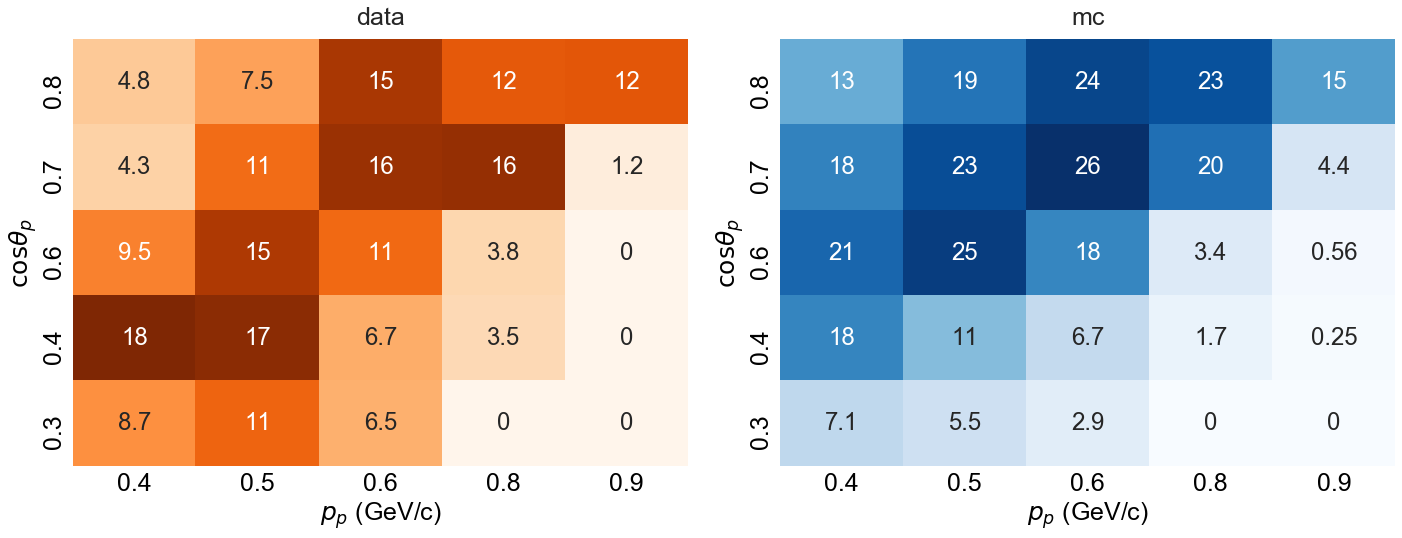

In [33]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(1,2,1)
sns.heatmap(Xsec_2d.T,annot=True,cmap='Oranges',cbar=False            
            ,xticklabels=['%.1f'%x for x in Centers['Pp']]
            ,yticklabels=['%.1f'%x for x in Centers['cos(theta(p))']]
           )
set_axes(ax,r'$p_p$ (GeV/c)',r'$\cos\theta_p$',title='data')
ax.invert_yaxis()

ax = fig.add_subplot(1,2,2)
sns.heatmap(mc_Xsec_2d.T,annot=True,cmap='Blues',cbar=False
            ,xticklabels=['%.1f'%x for x in Centers['Pp']]
            ,yticklabels=['%.1f'%x for x in Centers['cos(theta(p))']])
set_axes(ax,r'$p_p$ (GeV/c)',r'$\cos\theta_p$',title='mc')
ax.invert_yaxis()

plt.tight_layout()